# Utility Theory

This notebook summarizes basic utility theory and how it can be used in portfolio optimisation.

## Load Packages and Extra Functions

In [1]:
using Printf, LinearAlgebra, Optim             #Optim is an optimization package

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Utility Function

The CRRA utility function is $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$

### A Remark on the Code

A Julia function can be created in several ways. For a simple one-liner, it is enough to do like this:
`MySum(x,y) = x + y`

In [3]:
"""
    U(x,γ)

CRRA utility function, γ is the risk aversion.

"""
U(x,γ)   =  x^(1-γ)/(1-γ)



"""
    U_1(u,γ)

Inverse of CRRA utility function. Solves for x st. U(x,γ) = u.
"""
U_1(u,γ) = (u*(1-γ))^(1/(1-γ))

U_1

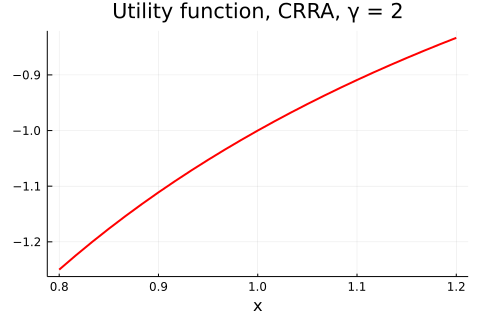

In [4]:
x = range(0.8,1.2,length=25)
γ = 2

p1 = plot( x,U.(x,γ),
           linecolor = :red,
           linewidth = 2,
           legend = false,
           title = "Utility function, CRRA, γ = $γ",
           xlabel = "x" )
display(p1)

# Expected Utility

Recall: if $\pi_s$ is the probability of outcome ("state") $x_s$ and there are $S$ possible outcomes, then expected utility is

$\text{E}U(x) = \sum\nolimits_{s=1}^{S} \pi_{s}U(x_s)$

### A Remark on the Code

When `x` is a vector, then `U.(x,γ)` is a vector of the corresponding utility values. `sum(π.*U.(x,γ))` calculates the inner product of the two vectors, that is, summing `π[i]*U(x[i],γ)` across all `i`. Clearly, this could be done in a loop instead or by `π'*U.(x,γ)`.

In [5]:
"""
    EU(π,x,γ)

Calculate expected CRRA utility from a vector of outcomes `x` and their probabilities `π`.


"""
EU(π,x,γ) = sum(π.*U.(x,γ))

EU

In [6]:
γ = 2                   #risk aversion

x₁ = 0.85               #possible outcomes
x₂ = 1.15
π₁ = 0.5                #probabilities of outcomes 
π₂ = 1 - π₁

state₁ = [x₁,U(x₁,γ),π₁]     #for printing
state₂ = [x₂,U(x₂,γ),π₂]

printblue("Different states: wealth, utility and probability:\n")
printmat([state₁ state₂],colNames=["state 1","state 2"],rowNames=["wealth","utility","probability"])

Ex      = sum([π₁,π₂].*[x₁,x₂])   #expected wealth
ExpUtil = EU([π₁,π₂],[x₁,x₂],γ)   #expected utility

printmat([Ex,ExpUtil],rowNames=["Expected wealth","Expected utility"])

Different states: wealth, utility and probability:

              state 1   state 2
wealth          0.850     1.150
utility        -1.176    -0.870
probability     0.500     0.500

Expected wealth      1.000
Expected utility    -1.023



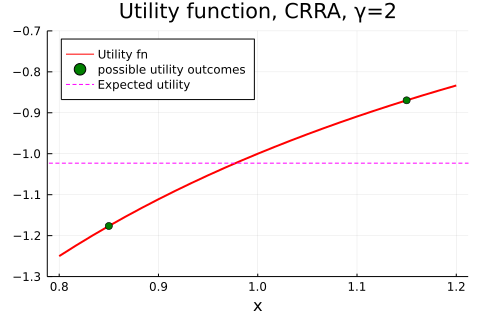

In [7]:
p1 = plot( x,U.(x,γ),
           linecolor = :red,
           linewidth = 2,
           label = "Utility fn",
           ylim = (-1.3,-0.7),
           legend = :topleft,
           title = "Utility function, CRRA, γ=$γ",
           xlabel = "x" )
scatter!([x₁,x₂],U.([x₁,x₂],γ),markercolor=:green,label="possible utility outcomes")
hline!([ExpUtil],linecolor=:magenta,line=(:dash,1),label="Expected utility")
display(p1)

# Certainty Equivalent

The certainty equivalent (here denoted $P$) is the sure value that solves 

$U(P) = \text{E}U(x)$,

where the right hand side is the expected utility from the random $x$. $P$ is the highest price the investor is willing to pay for "asset" $x$.

The code below solves for $P$ by inverting the utility function, first for the same $\gamma$ as above, and later for different values of the risk aversion.

We can think of E$(x)/P-1$ as the expected return on $x$ that investor require in order to buy the asset. It is increasing in the risk aversion $\gamma$.

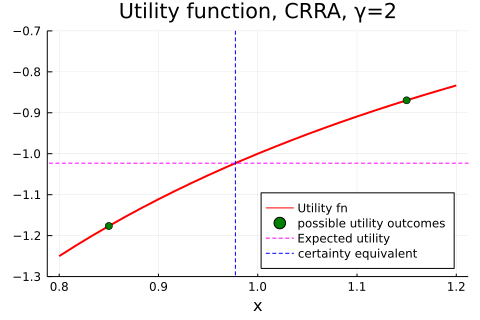

In [8]:
EU_i = EU([π₁,π₂],[x₁,x₂],γ)     #expected utility
P    = U_1(EU_i,γ)               #certainty equivalent (inverting the utility fn)

p1 = plot( x,U.(x,γ),
           linecolor = :red,
           linewidth = 2,
           label = "Utility fn",
           ylim = (-1.3,-0.7),
           legend = :bottomright,
           title = "Utility function, CRRA, γ=$γ",
           xlabel = "x" )
scatter!([x₁,x₂],U.([x₁,x₂],γ),markercolor=:green,label="possible utility outcomes")
hline!([ExpUtil],linecolor=:magenta,line=(:dash,1),label="Expected utility")
vline!([P],linecolor=:blue,line=(:dash,1),label="certainty equivalent")
display(p1)

In [9]:
γ  = [0,2,5,10,25,50,100]               #different risk aversions
L  = length(γ)

(P,ERx) = (fill(NaN,L),fill(NaN,L))
for i = 1:L
    #local EU_i                         #local/global is needed in script
    EU_i   = EU([π₁,π₂],[x₁,x₂],γ[i])   #expected utility with γ[i]
    P[i]   = U_1(EU_i,γ[i])             #inverting the utility fn
    ERx[i] = Ex/P[i] - 1                #required expected net return
end

printblue("risk aversion and certainly equivalent (recall: E(wealth) = $Ex):\n")
printmat([γ P ERx],colNames= ["γ","certainty eq","expected return"],width=20)

risk aversion and certainly equivalent (recall: E(wealth) = 1.0):

                   γ        certainty eq     expected return
               0.000               1.000               0.000
               2.000               0.977               0.023
               5.000               0.947               0.056
              10.000               0.912               0.097
              25.000               0.875               0.143
              50.000               0.862               0.160
             100.000               0.856               0.168



# Portfolio Choice with One Risky Asset

In the example below, the investor maximizes $\text{E}\ln (1+R_{p})\text{, with }R_{p}=vR_{1} + (1-v)R_{f}$ by choosing $v$. There are two possible outcomes for $R_{1}$ with equal probabilities.

This particular problem can be solved by pen and paper, but this becomes very difficult when the number of states increases - and even worse when there are many assets. To prepare for these tricker cases, we apply a numerical optimization algorithm already to this simple problem.

### Remark on the Code

To solve the optimization problem we use `optimize()` from the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package. The key steps are:

1. Define a function for expected utility, `EUlog(v,π,Re,Rf)`. The value depends on the portfolio choice `v`, as well as the properties of the asset (probabilities and returns for different states).

2. To create data for the plot, we loop over `v[i]` values and calculate expected utility as `EUlog(v[i],π,Re,Rf)` where 
`π` and `Re` are vectors of probabilities and returns in the different states, and the riskfree rate `Rf` is the same in all states. (Warning: you can assign a value to `π` provided you do not use the built-in constant `π` (3.14156...) first.)

3. For the optimization, we minimize the anonymous function `v->-EUlog(v,π,Re,Rf)`. This is a function of `v` only and we use the negative value since `optimize()` is a *minimization* routine.

In [10]:
"""
    EUlog(v,π,Re,Rf)

Calculate expected utility (log(1+Rp)) from investing into one risky and one riskfree asset

v:  scalar
π:  S vector probabilities of the different states
Re: S vector, excess returns of the risky asset in different states
Rf: scalar, riskfree rate

"""
function EUlog(v,π,Re,Rf)         #expected utility, utility fn is logarithmic
    R  = Re .+ Rf
    Rp = v*R .+ (1-v)*Rf          #portfolio return
    eu = sum(π.*log.(1.0.+Rp))    #expected utility
    return eu
end

EUlog

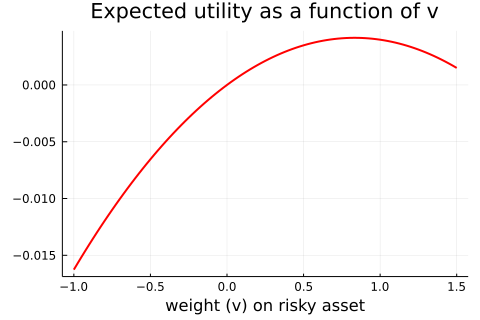

In [11]:
π  = [0.5,0.5]                 #probabilities for different states
Re = [-0.10,0.12]              #excess returns in different states
Rf = 0                         #riskfree rate

v = range(-1,1.5,length=101)    #try different weights on risky asset
L = length(v)
EUv = fill(NaN,L)
for i = 1:L
    EUv[i] = EUlog(v[i],π,Re,Rf)
end

p1 = plot( v,EUv,
           linecolor = :red,
           linewidth = 2,
           legend = false,
           title = "Expected utility as a function of v",
           xlabel = "weight (v) on risky asset" )
display(p1)

In [12]:
Sol = optimize(v->-EUlog(v,π,Re,Rf),-1,1)  #minimize -EUlog
printlnPs("Optimum at: ",Optim.minimizer(Sol))

printred("\nCompare with the figure")

Optimum at:      0.833

Compare with the figure


# Portfolio Choice with Several Risky Assets

This optimization problem has several risky assets and states and a general CRRA utility function. Numerical optimization is still straightforward.

### A Remark on the Code

The code below is fairly similar to the log utility case solved before, but extended to handle CRRA utility and several assets and states.

With several choice variables, the call to `optimize()` requires a vector of starting guesses as input.

In [13]:
"""
    EUcrra(v,π,R,Rf,γ)

Calculate expected utility from investing into n risky assets and one riskfree asset

v:  n vector (weights on the n risky assets)
π:  S vector (S possible "states")
R:  nxS matrix, each column is the n vector of returns in one of the states
Rf: scalar, riskfree rate
γ:  scalar, risk aversion
"""
function EUcrra(v,π,R,Rf,γ)
    S  = length(π)
    Rp = fill(NaN,S)
    for i = 1:S           #portfolio return in each state
        Rp[i] = v'R[:,i] + (1-sum(v))*Rf
    end
    eu = EU(π,1.0.+Rp,γ)  #expected utility when using portfolio v
    return eu
end

EUcrra

In [14]:
Re = [-0.03 0.08 0.20;           #2 assets, 3 states
      -0.04 0.22 0.15]           #Re[i,j] is the excess return of asset i in state j
π = [1/3,1/3,1/3]                #probs of the states
Rf = 0.065
γ  = 5

Sol = optimize(v->-EUcrra(v,π,Re,Rf,γ),[-0.6,1.2])     #minimize -EUcrra
v = Optim.minimizer(Sol)

printblue("optimal portfolio weights from max EUcrra():\n")
printmat([v;1-sum(v)],rowNames=["asset 1","asset 2","riskfree"])

optimal portfolio weights from max EUcrra():

asset 1     -0.726
asset 2      1.317
riskfree     0.409



# Mean-Variance and the Telser Criterion

Let $\mu$ be a vector of expected returns and $\Sigma$ be the covariance matrix of the investible assets.

The Telser criterion solves the problem

$\max_{v} \mu_{p} \: \text{ subject to} \:  \text{VaR}_{95\%} < 0.1$,

where $\mu_{p} = v'\mu+(1-v)R_f$ is the expected portfolio return.

If the returns are normally distributed then 

$\text{VaR}_{95\%} = -(\mu_p - 1.64\sigma_p)$,

where $\sigma_p = \sqrt{v'\Sigma v}$ is the standard deviation of the portfolio return. It follows that the VaR restriction can be written $-(\mu_p - 1.64\sigma_p) < 0.1$, which implies that the following must hold

$\mu_p > -0.1 + 1.64\sigma_p$.

The figure below illustrates that the optimal portfolio is on the CLM (when the returns are normally distributed).

It can be shown (see lecture notes) that the return of rhe optimal portfolio is 
$R_{opt} = vR_T + (1-v)R_f$, 
where $R_T$ is the return of the tangency portfolio. The $v$ value is

\begin{equation}
v=-\frac{R_{f}+V^{\ast}}{c\sigma_{T}+\mu_{T}^{e}},
\end{equation}

where $V^{\ast}$ is the VaR restriction (here 0.1) and $c$ is the critical value corresponding to the 1- confidence level of the VaR (here $c=-1.64$ since we use the 95% confidence level).

In [15]:
include("jlFiles/MvCalculations.jl")    #functions for traditional MV frontiers

MVTangencyP

In [16]:
μ = [9, 6]/100                       #means of investable assets
Σ = [ 256    0;                      #covariance matrix
        0  144]/10000
Rf = 1/100

μstar = range(Rf,0.1,length=101)      #required average returns
L     = length(μstar)

(StdRp_a,StdRp_b) = (fill(NaN,L),fill(NaN,L))
for i = 1:L
    StdRp_a[i] = MVCalc(μstar[i],μ,Σ)[1]       #std of MVF (risky only) at μstar
    StdRp_b[i] = MVCalcRf(μstar[i],μ,Σ,Rf)[1]  #std of MVF (risky&riskfree) at μstar
end

VaRRestr = -0.1 .+ 1.64*StdRp_b;    #portfolio mean return must be above this

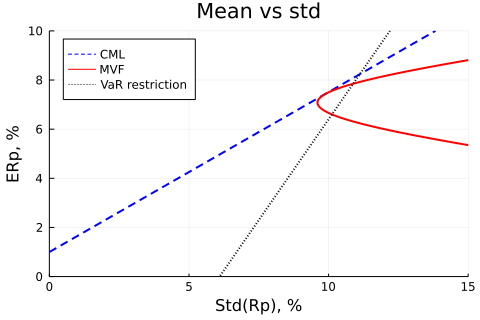

In [17]:
p1 = plot( [StdRp_b StdRp_a StdRp_b]*100,[μstar μstar VaRRestr]*100,
           linestyle = [:dash :solid :dot],
           linecolor = [:blue :red :black],
           linewidth = 2,
           label = ["CML" "MVF" "VaR restriction"],
           xlim = (0,15),
           ylim = (0,10),
           legend = :topleft,
           title = "Mean vs std",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
display(p1)

The next few cells shows the explicit solution of Telser problem, assuming normally distributed returns.

In [18]:
"""
    TelserSolution(μeT,σT,Rf,Varstar,c)

Calculate v in Rp = v*RT + (1-v)Rf which maximizes the Telser criterion,
assuming normally distributed returns. RT is the return on the tangency
portfolio and Rf is the riskfree rate.

The solution is derived in the lecture notes.
"""
function TelserSolution(μeT,σT,Rf,Varstar,c)
    v = - (Rf+Varstar)/(c*σT+μeT)
    return v
end

TelserSolution

In [19]:
(wT,μT,σT) = MVTangencyP(μ,Σ,Rf)        #tangency portfolio from (μ,Σ)
printlnPs("Mean and std of tangency portfolio ",μT,σT)

v = TelserSolution(μT-Rf,σT,Rf,0.1,-1.64)

printblue("\nOptimal portfolio, weight on tangency portfolio and riskfree:")
printmat([v,1-v],rowNames=["tangency","riskfree"])

μOpt = v*μT + (1-v)*Rf                  #mean and std of optimal portfolio
σOpt = abs(v)*σT

printblue("\nMean and std of optimal portfolio:")
printlnPs(μOpt,σOpt)

printred("\ncompare with the figure")

Mean and std of tangency portfolio      0.074     0.099

Optimal portfolio, weight on tangency portfolio and riskfree:
tangency     1.127
riskfree    -0.127


Mean and std of optimal portfolio:
     0.082     0.111

compare with the figure
